# Yelp grossometer

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

main_directory = r'C:\Users\ASUS\Desktop\ML-data science\DataIncubator\yelp-cleaners' + '\\'
processed_data_directory = main_directory + r'data\processed data' + '\\'

In [3]:
business_df_latest = pd.read_csv(processed_data_directory + 'business_df_latest_inspection.csv')
business_df = pd.read_csv(processed_data_directory + 'business_df.csv')
review_df = pd.read_csv(processed_data_directory + 'review_df.csv')

In [3]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor, LogisticRegression
from sklearn import datasets, tree, utils
from sklearn import model_selection, ensemble
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.preprocessing import MinMaxScaler
from collections import Counter, OrderedDict

In [4]:
import spacy
# nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS
STOP_WORDS = STOP_WORDS.union({'ll', 've'})
from sklearn.naive_bayes import MultinomialNB, GaussianNB

# bag of words model

## dataset subset

In [16]:
df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_no_limit_df.csv')
# df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_2_years_df.csv')

In [17]:
# let's just look at businesses with >20 reviews
# num_reviews = df.business_id.value_counts()
# valid_businesses = num_reviews[num_reviews >= 20].index
# df = df[df['business_id'].isin(valid_businesses)].reset_index(drop=True)

In [18]:
len(df.groupby(['business_id']).groups)

2506

In [19]:
len(df.groupby(['business_id','Score']).groups)

6617

In [185]:
# # let's just look at businesses with 50-100 reviews
# num_reviews = df.business_id.value_counts()
# valid_businesses = num_reviews[(num_reviews <= 100) & (num_reviews >= 50)].index
# df = df[df['business_id'].isin(valid_businesses)].reset_index(drop=True)

In [20]:
df

,business_id,review_id,text,date,review_stars,Score,stars
0,NRPemqVb4qpWFF0Avq_6OQ,058Ifx7-wXugpY2CO3X4gA,We went tonight following our favorite new Sus...,2017-03-17 01:53:14,5,76.0,4.5
1,NRPemqVb4qpWFF0Avq_6OQ,iqgH--t6KCxocbniQE87EQ,First Indonesian Owned restaurant I found that...,2017-03-18 22:03:24,5,76.0,4.5
2,NRPemqVb4qpWFF0Avq_6OQ,sCZ7J-35Ro4FHEXBmUShHw,A great addition to the area! Personnel are ve...,2017-03-19 23:45:12,5,76.0,4.5
3,NRPemqVb4qpWFF0Avq_6OQ,jmfkhC53ETKV3Dzsq7bBOw,Pleasantly surprised by the energy that went i...,2017-03-21 19:34:06,5,76.0,4.5
4,NRPemqVb4qpWFF0Avq_6OQ,bzZ-Ei2AQDI7uEfnUv6R0g,Good food and very friendly wait staff. Best s...,2017-03-22 00:28:22,5,76.0,4.5
...,...,...,...,...,...,...,...
570609,EaBDXdIQ_TeeUhn1Twnjvg,o7KKw9gZ1zADWR3OvwJOjQ,I've heard only good things about this noodle ...,2019-10-28 02:35:05,5,73.0,3.5
570610,EaBDXdIQ_TeeUhn1Twnjvg,vKLOotHW3NGAWGd_AKmrxw,I've had a very hot or miss experience with sh...,2019-11-20 00:57:20,4,73.0,3.5
570611,EaBDXdIQ_TeeUhn1Twnjvg,RqU0sEZcHc25RWap4v9_5A,The best Chinese food we have found in the are...,2019-11-23 21:38:24,5,73.0,3.5
570612,EaBDXdIQ_TeeUhn1Twnjvg,zvZR61Ioy-5dhw_3Q3kPFw,This is a small and simple restaurant but such...,2020-01-17 01:25:08,5,73.0,3.5


In [21]:
reviews = np.array(df['text'])
scores = np.array(df['Score'])

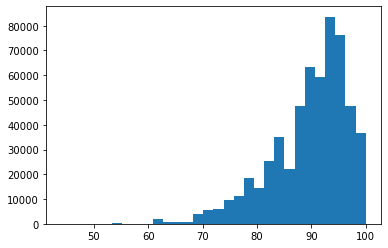

In [24]:
# scores look skewed, maybe do logistic regression?
plt.hist(scores,bins=30)
plt.show()

## bow linear model

In [100]:
# df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_no_limit_df.csv')
df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_2_years_df.csv')

In [101]:
# let's just look at businesses with >100 reviews
num_reviews = df.business_id.value_counts()
valid_businesses = num_reviews[num_reviews >= 100].index
df = df[df['business_id'].isin(valid_businesses)].reset_index(drop=True)

In [231]:
# test with small data
X, y = shuffle(reviews, scores, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [232]:
len(X_train)

173293

In [269]:
%%time
# bow_vectorizer = CountVectorizer(min_df=10,max_df=0.75)
bow_vectorizer = TfidfVectorizer(min_df=5,
                                 max_df=0.5,
                                 max_features=20000,
                                 stop_words=STOP_WORDS)
est = Pipeline([
    ('vect', bow_vectorizer),
    ('regressor', Ridge(alpha=10))
])
est.fit(X_train, y_train)
print(f'R^2 score: {est.score(X_test, y_test)}')

R^2 score: 0.2027936585513943
Wall time: 25.1 s


In [279]:
est.named_steps['vect'].get_feature_names_out()

array(['00', '000', '007', ..., 'zushi', 'zuzu', 'étouffée'], dtype=object)

In [260]:
parameters = {
    'vect__max_features': [20000]
#     'vect__max_df': [0.25,0.5,0.75]
    # 'regressor__alpha': [0.001,1.0]
}
gs = GridSearchCV(est, parameters)

In [261]:
%%time
gs.fit(X,y)

Wall time: 6min 8s


GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(max_df=0.5,
                                                        max_features=10000,
                                                        min_df=5,
                                                        stop_words={"'d", "'ll",
                                                                    "'m", "'re",
                                                                    "'s", "'ve",
                                                                    'a',
                                                                    'about',
                                                                    'above',
                                                                    'across',
                                                                    'after',
                                                                    'afterwards',
                                   

In [262]:
gs.best_params_

{'vect__max_features': 20000}

In [266]:
parameters = {
    'vect__min_df': [3,5,10]
#     'vect__max_df': [0.25,0.5,0.75]
    # 'regressor__alpha': [0.001,1.0]
}
gs = GridSearchCV(est, parameters)

In [267]:
%%time
gs.fit(X,y)

Wall time: 6min


GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(max_df=0.5,
                                                        max_features=20000,
                                                        min_df=5,
                                                        stop_words={"'d", "'ll",
                                                                    "'m", "'re",
                                                                    "'s", "'ve",
                                                                    'a',
                                                                    'about',
                                                                    'above',
                                                                    'across',
                                                                    'after',
                                                                    'afterwards',
                                   

In [268]:
gs.best_params_

{'vect__min_df': 5}

In [270]:
parameters = {
    # 'vect__min_df': [5,10,100]
    'vect__max_df': [0.5,0.75,0.9]
    # 'regressor__alpha': [0.001,1.0]
}
gs = GridSearchCV(est, parameters)

In [271]:
%%time
gs.fit(X,y)

Wall time: 6min 38s


GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(max_df=0.5,
                                                        max_features=20000,
                                                        min_df=5,
                                                        stop_words={"'d", "'ll",
                                                                    "'m", "'re",
                                                                    "'s", "'ve",
                                                                    'a',
                                                                    'about',
                                                                    'above',
                                                                    'across',
                                                                    'after',
                                                                    'afterwards',
                                   

In [272]:
gs.best_params_

{'vect__max_df': 0.5}

In [249]:
parameters = {
    # 'vect__min_df': [5,10,100]
    # 'vect__max_df': [0.25,0.5,0.75]
    'regressor__alpha': [0.001,0.1,1.0,10.0]
}
gs = GridSearchCV(est, parameters)

In [250]:
%%time
gs.fit(X,y)

Wall time: 7min 23s


GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(max_df=0.75,
                                                        max_features=5000,
                                                        min_df=10,
                                                        stop_words={"'d", "'ll",
                                                                    "'m", "'re",
                                                                    "'s", "'ve",
                                                                    'a',
                                                                    'about',
                                                                    'above',
                                                                    'across',
                                                                    'after',
                                                                    'afterwards',
                                  

In [251]:
gs.best_params_

{'regressor__alpha': 10.0}

In [84]:
high_value_terms = dict(zip(bow_vectorizer.vocabulary_, bow_vectorizer.idf_))
high_value_terms = dict(sorted(high_value_terms.items(), key=lambda item: item[1],reverse=False))
high_value_terms

{'heads': 1.800982361333924,
 'utensils': 1.916643059857872,
 'hover': 1.943903566500662,
 'veg': 2.085777785684223,
 'positives': 2.301467895157769,
 'underground': 2.3325902921599235,
 'mega': 2.478139828925632,
 'father': 2.5676060379729577,
 'reasonably': 2.7504004434583775,
 'attitude': 2.7677003911179354,
 'sriracha': 2.8424380217217284,
 'quail': 2.860957778707466,
 'sweating': 2.882951459349991,
 'deny': 2.9016483636276744,
 'pears': 2.9054882547626635,
 'scheme': 2.9363331638248127,
 'bravo': 2.9558104185231615,
 'forming': 3.0278544549869055,
 'paradise': 3.034545037094106,
 'belt': 3.037436729642962,
 'patient': 3.040429305859377,
 'bombay': 3.0561292106755484,
 'intimidated': 3.0668230852583847,
 'kick': 3.112588102383234,
 'managed': 3.1146183982696543,
 'ball': 3.1178314928864945,
 'diversity': 3.131699777350294,
 'lessons': 3.131943027169056,
 'arrival': 3.160840530864127,
 'succeed': 3.2127479628498827,
 'ray': 3.2321225216819744,
 'boba': 3.233916887855153,
 'wish': 3.

In [85]:
high_value_terms['clean']

9.078337227187573

In [86]:
high_value_terms['gross']

6.761895099532101

(array([   7.,   27.,  100.,  229.,  393.,  645.,  982., 1509., 2199.,
        3148.]),
 array([1.80098236, 2.55318704, 3.30539171, 4.05759639, 4.80980106,
        5.56200574, 6.31421041, 7.06641509, 7.81861976, 8.57082444,
        9.32302911]),
 <BarContainer object of 10 artists>)

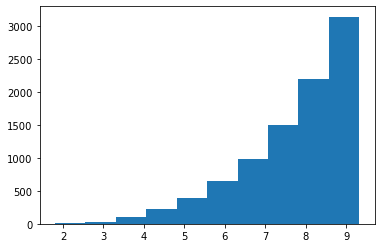

In [75]:
plt.hist(high_value_terms.values())

## classifier with rounded scores

In [5]:
df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_no_limit_df.csv')
# df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_2_years_df.csv')

In [6]:
# let's just look at businesses with >100 reviews
num_reviews = df.business_id.value_counts()
valid_businesses = num_reviews[num_reviews >= 100].index
df = df[df['business_id'].isin(valid_businesses)].reset_index(drop=True)

In [7]:
# only look at outraged customers
df = df[df.review_stars <= 3]

In [15]:
reviews = np.array(df['text'])
scores = np.array(df['Score'])
cutoff = -1
X, y = reviews[:cutoff], scores[:cutoff]
# # round
# roundby = 1
# y = np.array(list(map(lambda x: math.ceil(x / roundby) * roundby,y)))
# classify into two categories
thresh = 80
# y = np.array(list(map(lambda x: math.ceil(x / roundby) * roundby,y))) # round
y = np.array(list(map(lambda x: 1 if x > thresh else 0, y)))

In [16]:
bow_vectorizer = TfidfVectorizer(min_df=10,
                                 max_df=0.5,
                                 max_features=20000,
                                 ngram_range=(1,2),
                                 stop_words=STOP_WORDS)
# svd = TruncatedSVD(n_components=100)
features = Pipeline([
    ('tfidf',bow_vectorizer),
    ('svd',TruncatedSVD(n_components=100)),
    ('minmax',MinMaxScaler(feature_range=(0,1))) # necessary for NB
])

In [110]:
# # looking at high tf-idf terms
# high_value_terms = dict(zip(features.named_steps.tfidf.vocabulary_, features.named_steps.tfidf.idf_))
# high_value_terms = dict(sorted(high_value_terms.items(), key=lambda item: item[1],reverse=False))
# high_value_terms

In [17]:
%%time
X_out = features.fit_transform(X,y)

Wall time: 1min 30s


In [18]:
X_out_shuff, y_shuff = shuffle(X_out, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_out_shuff, y_shuff, test_size=0.2, random_state=42)

In [19]:
def test_regressor(regressor,print_R2=True,residual_hist=True,predictions_hist=True):
    regressor.fit(X_train,y_train)
    if print_R2:
        print(f'R^2 score: {regressor.score(X_test, y_test)}')
    y_predict = regressor.predict(X_test)
    if residual_hist:
        fig = plt.figure(1)
        plt.hist(y_predict-y_test,bins=30,alpha=0.5);
        plt.show()
    if predictions_hist:
        fig = plt.figure(2)
        plt.hist(y_predict,bins=30,alpha=0.5)
        plt.hist(y_test,bins=30,alpha=0.5)
        plt.show()

R^2 score: 0.05001252597549255


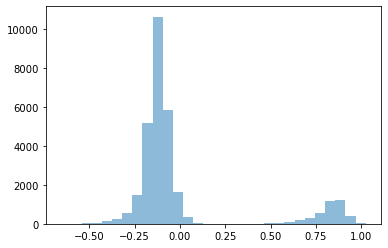

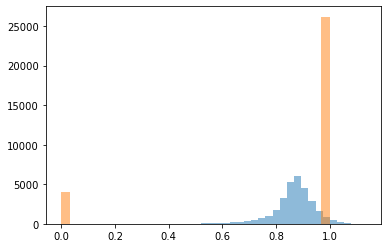

Wall time: 1.24 s


In [20]:
%%time
test_regressor(regressor = Ridge(alpha=10))

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


R^2 score: 0.8647809133566849


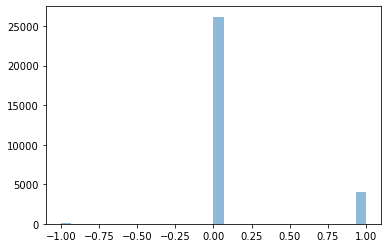

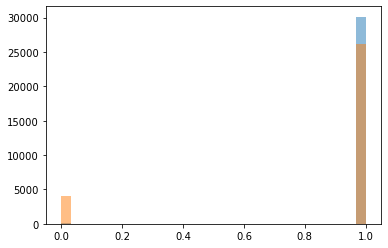

Wall time: 5.16 s


In [25]:
%%time
test_regressor(regressor = LogisticRegression(solver = 'lbfgs', max_iter=100))

R^2 score: 0.8648139580992664


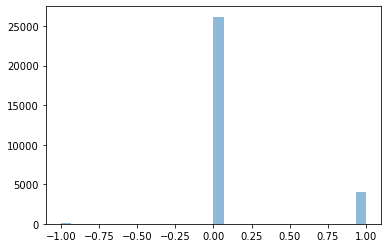

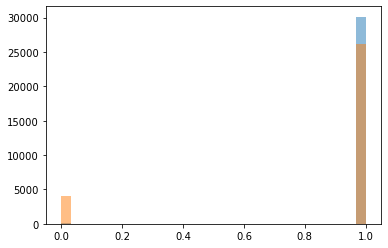

Wall time: 6.41 s


In [26]:
%%time
test_regressor(regressor = LogisticRegression(solver = 'lbfgs', max_iter=500))

In [22]:
priors = OrderedDict(sorted(Counter(y_test).items()))
priors = np.fromiter(priors.values(), dtype=float)/len(y_test)

R^2 score: 0.8652435397528253


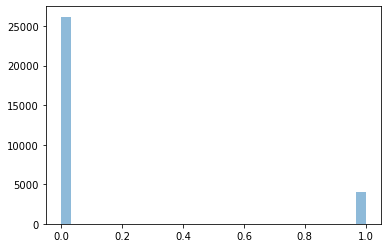

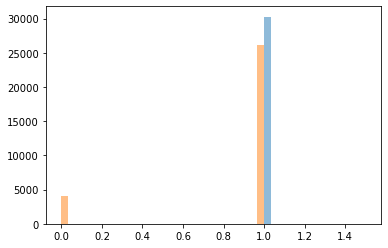

Wall time: 1.39 s


In [24]:
%%time
regressor = MultinomialNB()
test_regressor(regressor)

In [80]:
reviews[-3]

'This is my go to Chinese restaurant when you want to eat good. Orders come with soup and a spring roll and always provide sweet and sour dipping for the rolls. You get a lot of food! My go to is the combination fried rice.'

In [57]:
%%time
parameters = {
    'var_smoothing': np.logspace(-9,1,11)
}
gs = GridSearchCV(regressor, parameters)
gs.fit(X_test,y_test)
gs.best_params_

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Wall time: 13.2 s


{'var_smoothing': 1.0}

R^2 score: 0.28836072427877657


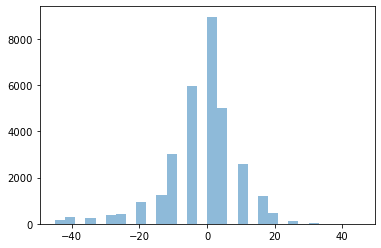

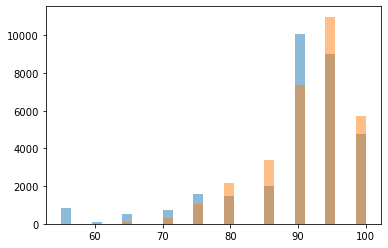

Wall time: 2.32 s


In [58]:
%%time
regressor = GaussianNB(priors=prior, var_smoothing=1e-9)
test_regressor(regressor)

In [59]:
%%time
parameters = {
    'var_smoothing': np.logspace(-9,1,11)
}
gs = GridSearchCV(regressor, parameters)
gs.fit(X_test,y_test)
gs.best_params_

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Wall time: 13.1 s


{'var_smoothing': 1.0}

(array([ 1561.,    31.,   346.,   506.,   575.,   274.,   302.,  7706.,
        15916.,  3876.]),
 array([ 55. ,  59.5,  64. ,  68.5,  73. ,  77.5,  82. ,  86.5,  91. ,
         95.5, 100. ]),
 <BarContainer object of 10 artists>)

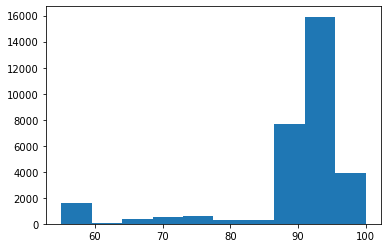

In [40]:
plt.hist(regressor.predict(X_test))

R^2 score: 0.5407326407873154


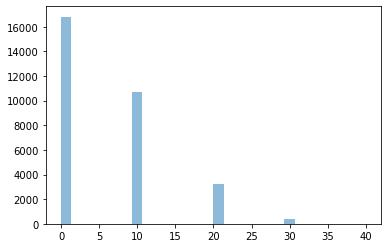

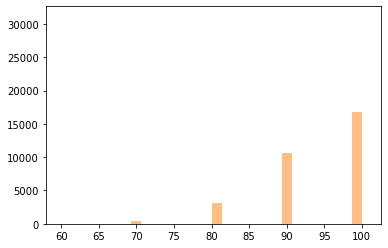

Wall time: 711 ms


In [400]:
%%time
# this only works for two classes
test_regressor(regressor = MultinomialNB())

In [403]:
regressor = MultinomialNB()
regressor.fit(X_train,y_train)
print(f'R^2 score: {regressor.score(X_test, y_test)}')
y_predict = regressor.predict(X_test)

R^2 score: 0.5407326407873154


In [405]:
min(y_predict)

100

## full model (takes too long)

In [5]:
# df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_no_limit_df.csv')
df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_2_years_df.csv')

In [6]:
# let's just look at businesses with >100 reviews
num_reviews = df.business_id.value_counts()
valid_businesses = num_reviews[num_reviews >= 100].index
df = df[df['business_id'].isin(valid_businesses)].reset_index(drop=True)

In [7]:
# only look at outraged customers
df = df[df.review_stars <= 3]

In [52]:
reviews = df['text']
scores = df['Score']
cutoff = 10000
X, y = shuffle(reviews, scores, random_state=42)[:cutoff]
roundby = 5
y = np.array(list(map(lambda x: math.ceil(x / roundby) * roundby,y))) # round

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
bow_vectorizer = TfidfVectorizer(min_df=10,
                                 max_df=0.5,
                                 max_features=2000,
                                 ngram_range=(1,2),
                                 stop_words=STOP_WORDS)
features = Pipeline([
    ('tfidf',bow_vectorizer),
    ('svd',TruncatedSVD(n_components=100)),
    ('minmax',MinMaxScaler(feature_range=(0,1))) # necessary for NB
])

regressor = LogisticRegression(solver = 'lbfgs', max_iter=200)
model = Pipeline([
    ('features',features),
    ('est',regressor)
])

In [ ]:
%%time
X_out = features.fit_transform(X_train)
X_out_test = features.fit_transform(X_test)

In [ ]:
%%time
regressor.fit(X_out,y_train)

In [ ]:
%%time
model.fit(X_train,y_train)

In [24]:
model.score(X_test,y_test)

0.09055262835436834

In [41]:
y_predict = regressor.predict(X_out_test)

(array([2.000e+00, 2.100e+01, 1.300e+01, 2.480e+02, 2.800e+02, 6.140e+02,
        1.165e+03, 1.705e+03, 2.697e+03, 1.416e+03]),
 array([ 54. ,  58.6,  63.2,  67.8,  72.4,  77. ,  81.6,  86.2,  90.8,
         95.4, 100. ]),
 <BarContainer object of 10 artists>)

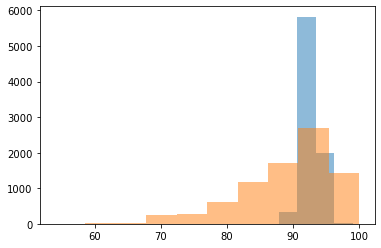

In [42]:
plt.hist(y_predict,alpha=0.5)
plt.hist(y_test,alpha=0.5)

(array([2.000e+00, 2.100e+01, 1.300e+01, 2.480e+02, 2.800e+02, 6.140e+02,
        1.165e+03, 1.705e+03, 2.697e+03, 1.416e+03]),
 array([ 54. ,  58.6,  63.2,  67.8,  72.4,  77. ,  81.6,  86.2,  90.8,
         95.4, 100. ]),
 <BarContainer object of 10 artists>)

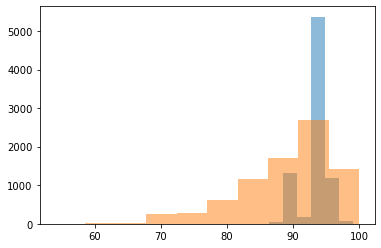

In [38]:
plt.hist(y_predict,alpha=0.5)
plt.hist(y_test,alpha=0.5)

In [35]:
X_test

6792      Save your time. Prices are just under Torchy's...
122955    This place doesn't care about take out orders....
154447    Owner messed up order after we had inquired wh...
112741    I think the rating for this place highly depen...
33541     This is a tough one because it was so close to...
                                ...                        
105114    Was not enjoyable, food was extremely salty. B...
16544     We went today to celebrate my daughter's 12th ...
79079     If you respect your taste buds you will not wa...
81659     While their happy hour offers some great deals...
4917      The chicken tacos were good. The problem is th...
Name: text, Length: 8161, dtype: object

In [32]:
model.predict(['absolutely disgusting gross dirty horrible nasty yucky shit'])

array([96])

In [33]:
model.predict(['spotless'])

array([96])